## Pasul 4 – Analiza exploratorie a datelor (EDA)

Scopul acestui pas este:
- calcularea statisticilor descriptive pentru datasetul agregat;
- explorarea evoluțiilor în timp pentru indicatorii energetici și socio-economici;
- evidențierea relațiilor dintre indicatorii EIA și WDI;
- identificarea unor tendințe și tipare preliminare care vor fundamenta analiza statistică ulterioară.

Unitatea de analiză este **țară × an**.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

sns.set(style="whitegrid", context="talk")

In [5]:
df = pd.read_csv("03_cleaning_aggregation_student3.csv")
df.head()

,countryRegionId,year,eia_primary_energy_44,eia_energy_intensity_47,eia_co2_emissions_4008,electricity_access,energy_use_per_capita,gdp_per_capita,renewables_share
0,BGR,2020,9.417170,101.126811,35.177193,99.7,2664.551530,10769.947570,21.1
1,BGR,2021,10.829147,111.358190,40.654544,99.8,2918.916414,12972.217336,20.4
2,BGR,2022,11.916742,115.032870,44.326275,100.0,2968.656634,13999.671920,20.4
3,BGR,2023,9.388583,101.609508,33.465186,100.0,2604.191045,15883.861855,20.4
4,CZE,2020,20.962717,147.140623,88.581957,100.0,3764.471612,23472.891545,17.0


## Statistici descriptive

Calculăm statistici descriptive pentru indicatorii energetici (EIA) și socio-economici (WDI),
pentru a înțelege ordinul de mărime, variația și distribuția acestora.

In [6]:
numeric_cols = df.select_dtypes(include="number").columns
df[numeric_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
year,24.0,2021.500000,1.142080,2020.000000,2020.750000,2021.500000,2022.250000,2023.000000
eia_primary_energy_44,24.0,19.642131,15.537011,5.622146,8.591998,16.186203,21.022322,54.070252
eia_energy_intensity_47,24.0,109.374374,26.965860,59.148450,101.488834,110.240158,124.916456,156.946789
eia_co2_emissions_4008,24.0,92.108004,90.058696,30.031405,38.915245,54.516225,89.377512,297.447061
electricity_access,24.0,99.979167,0.072106,99.700000,100.000000,100.000000,100.000000,100.000000
energy_use_per_capita,24.0,2808.234265,658.594589,1600.752364,2630.450656,2824.356771,3063.329723,4056.317001
gdp_per_capita,24.0,19442.164525,5200.169346,10769.947570,15802.367047,18763.361205,22186.992989,31591.056822
renewables_share,24.0,18.312500,3.079993,14.800000,15.300000,17.400000,20.400000,24.100000


### Concluzii – Statistici descriptive

Statisticile descriptive indică diferențe semnificative între țări în ceea ce privește
consumul de energie primară, intensitatea energetică și emisiile de CO₂.
Indicatorii energetici (EIA) prezintă o variabilitate ridicată, în timp ce indicatorii
socio-economici (WDI), precum accesul la electricitate, sunt mult mai omogeni între țări.
PIB-ul per capita și ponderea energiilor regenerabile arată variații moderate,
sugerând niveluri diferite de dezvoltare economică și tranziție energetică.

## Evoluții în timp ale indicatorilor energetici și economici

Analizăm evoluția în timp a principalilor indicatori, pentru a observa tendințe generale
și diferențe între țări.

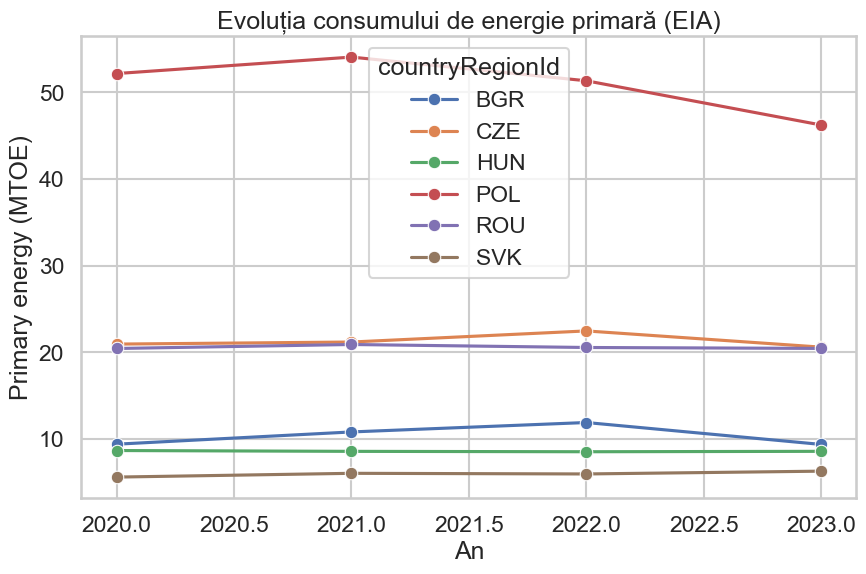

In [7]:
plt.figure(figsize=(10,6))
sns.lineplot(
    data=df,
    x="year",
    y="eia_primary_energy_44",
    hue="countryRegionId",
    marker="o"
)
plt.title("Evoluția consumului de energie primară (EIA)")
plt.ylabel("Primary energy (MTOE)")
plt.xlabel("An")
plt.show()


### Concluzii – Evoluția consumului de energie primară

Consumul de energie primară prezintă diferențe clare între țări, Polonia având
niveluri semnificativ mai ridicate față de celelalte economii analizate.
În majoritatea țărilor se observă o creștere sau stagnare până în 2022,
urmată de o scădere în 2023, ceea ce reflectă impactul crizei energetice
și ajustările recente ale cererii de energie.
Pattern-urile observate sunt consistente cu evoluțiile economice și energetice
din perioada analizată.

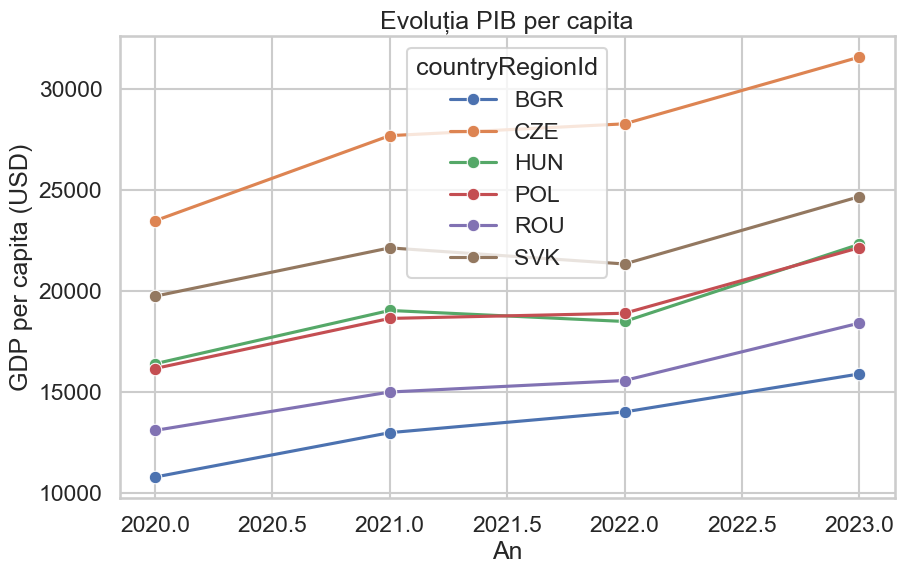

In [8]:
plt.figure(figsize=(10,6))
sns.lineplot(
    data=df,
    x="year",
    y="gdp_per_capita",
    hue="countryRegionId",
    marker="o"
)
plt.title("Evoluția PIB per capita")
plt.ylabel("GDP per capita (USD)")
plt.xlabel("An")
plt.show()


### Concluzii – Evoluția PIB-ului per capita

PIB-ul per capita a crescut constant în toate țările analizate în perioada
2020–2023, indicând o recuperare economică susținută după șocul pandemic.
Cehia se menține la un nivel semnificativ mai ridicat față de celelalte economii,
în timp ce Bulgaria și România pornesc de la niveluri mai scăzute, dar prezintă
ritmuri clare de convergență. Ușoarele stagnări observate în 2022 sunt consistente
cu contextul inflaționist și criza energetică.

### 4.3 Distribuția indicatorilor

Analizăm distribuția unor indicatori energetici cheie pentru a evidenția diferențele între țări și variația acestora în perioada 2020–2023.

Având în vedere numărul redus de observații (6 țări × 4 ani), utilizarea histogramelor agregate cu estimare KDE poate produce forme înșelătoare. Prin urmare, folosim reprezentări mai potrivite pentru acest tip de date:

#### Distribuția emisiilor de CO₂ (EIA)

Pentru emisiile de CO₂, utilizăm:
- **boxplot pe țări**, pentru a evidenția nivelul și variabilitatea emisiilor;
- **puncte individuale**, corespunzătoare fiecărei observații (țară–an).

#### Ponderea energiei regenerabile

Pentru energia regenerabilă, folosim un **bar chart al valorilor medii pe țări (2020–2023)**

/Users/catalinaminciuna/Library/CloudStorage/OneDrive-UniversitateaBabeş-Bolyai/masterat/fulx de date/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


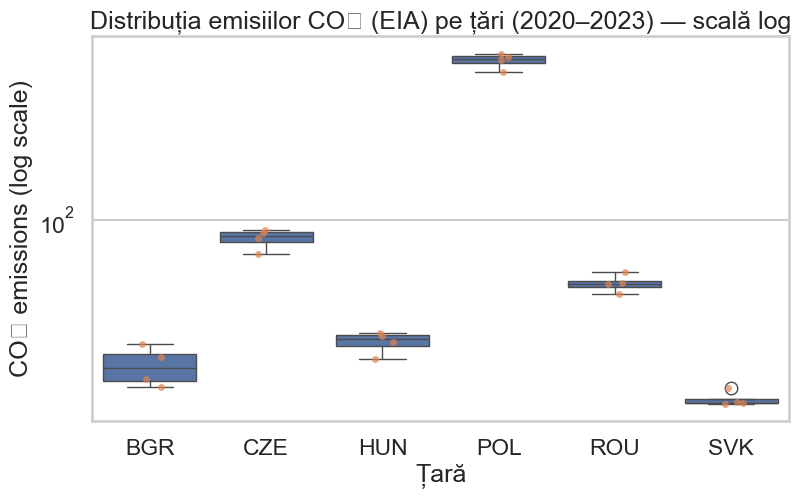

In [19]:
plt.figure(figsize=(9,5))

sns.boxplot(data=df, x="countryRegionId", y="eia_co2_emissions_4008")
sns.stripplot(data=df, x="countryRegionId", y="eia_co2_emissions_4008", jitter=True, alpha=0.7)

plt.yscale("log")
plt.title("Distribuția emisiilor CO₂ (EIA) pe țări (2020–2023) — scală log")
plt.xlabel("Țară")
plt.ylabel("CO₂ emissions (log scale)")
plt.show()


Pe scală log, diferențele relative dintre țări devin mai ușor de comparat, fără ca valorile mari (ex. POL) să domine vizual întregul grafic.

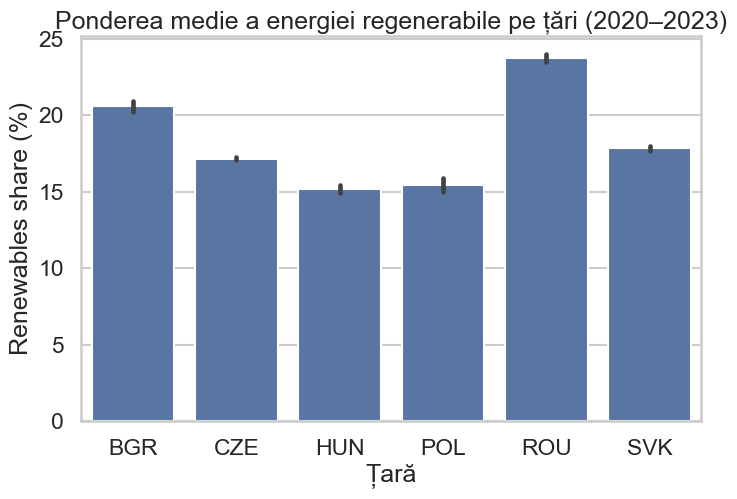

In [22]:
plt.figure(figsize=(8,5))

sns.barplot(
    data=df,
    x="countryRegionId",
    y="renewables_share",
    estimator="mean",
    errorbar="sd"
)

plt.title("Ponderea medie a energiei regenerabile pe țări (2020–2023)")
plt.xlabel("Țară")
plt.ylabel("Renewables share (%)")
plt.show()

Ponderea medie a energiei regenerabile diferă semnificativ între țările analizate în perioada 2020–2023. România înregistrează cea mai ridicată pondere a regenerabilelor, urmată de Bulgaria, în timp ce Ungaria și Polonia au cele mai scăzute valori. Cehia și Slovacia se situează la un nivel intermediar, indicând un mix energetic moderat orientat către surse regenerabile.

## 4.4 Relații între indicatorii energetici (EIA) și cei socio-economici (WDI)

Explorăm relațiile dintre nivelul de dezvoltare economică și indicatorii energetici,
folosind scatterplot-uri și corelații.


/Users/catalinaminciuna/Library/CloudStorage/OneDrive-UniversitateaBabeş-Bolyai/masterat/fulx de date/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


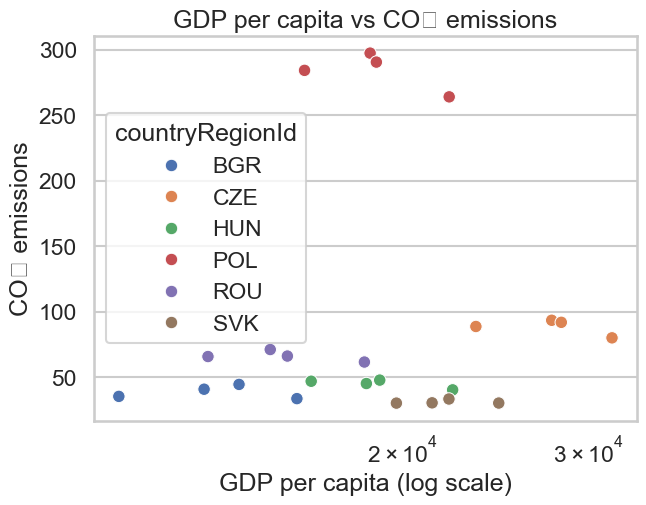

In [18]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=df,
    x="gdp_per_capita",
    y="eia_co2_emissions_4008",
    hue="countryRegionId"
)
plt.xscale("log")
plt.title("GDP per capita vs CO₂ emissions")
plt.xlabel("GDP per capita (log scale)")
plt.ylabel("CO₂ emissions")
plt.show()

Nu se observă o relație liniară clară între PIB per capita și nivelul emisiilor de CO₂ în eșantionul analizat. Țări cu niveluri similare de PIB pot avea emisii foarte diferite, sugerând că structura mixului energetic și eficiența energetică joacă un rol mai important decât nivelul de dezvoltare economică în explicarea emisiilor de CO₂.

In [12]:
x = df["gdp_per_capita"]
y = df["eia_co2_emissions_4008"]

mask = x.notna() & y.notna()
pearson_r, pearson_p = pearsonr(x[mask], y[mask])
spearman_r, spearman_p = spearmanr(x[mask], y[mask])

print(f"Pearson r = {pearson_r:.3f}, p-value = {pearson_p:.3f}")
print(f"Spearman r = {spearman_r:.3f}, p-value = {spearman_p:.3f}")

Pearson r = 0.049, p-value = 0.820
Spearman r = 0.134, p-value = 0.533


Corelația dintre PIB per capita și emisiile de CO₂.
Coeficientul Pearson (r = 0.049, p = 0.820) și coeficientul Spearman (r = 0.134, p = 0.533) indică o corelație foarte slabă și nesemnificativă statistic între PIB per capita și emisiile de CO₂ în eșantionul analizat. Acest rezultat sugerează că nivelul de dezvoltare economică, măsurat prin PIB per capita, nu explică direct variația emisiilor de CO₂, diferențele fiind mai degrabă determinate de structura energetică și eficiența utilizării energiei.

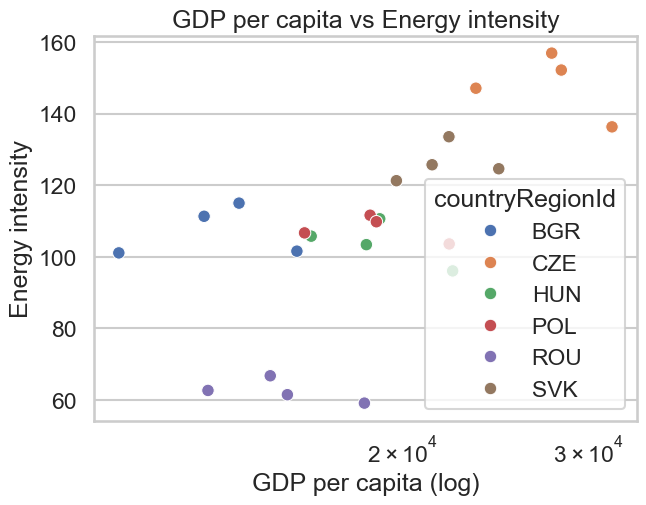

In [23]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=df,
    x="gdp_per_capita",
    y="eia_energy_intensity_47",
    hue="countryRegionId"
)
plt.xscale("log")
plt.title("GDP per capita vs Energy intensity")
plt.xlabel("GDP per capita (log)")
plt.ylabel("Energy intensity")
plt.show()

## 4.5 Matrice de corelații

Calculăm o matrice de corelații pentru variabilele numerice,
pentru a identifica relații liniare potențiale între indicatori.

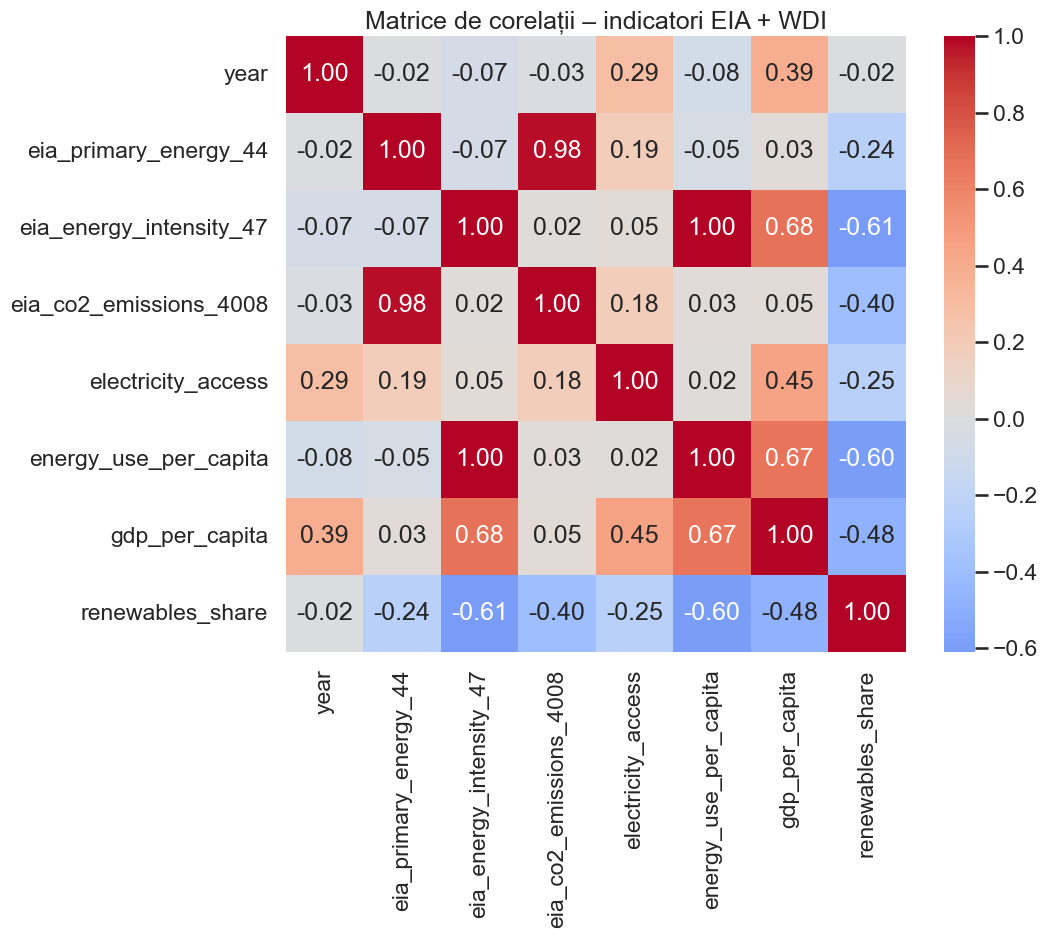

In [14]:
corr = df[numeric_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Matrice de corelații – indicatori EIA + WDI")
plt.show()

### Interpretare – matricea de corelații (EIA + WDI)

Matricea de corelații evidențiază câteva relații cheie între indicatorii energetici și cei socio-economici:

- **Consum de energie primară și emisii CO₂** prezintă o corelație foarte puternică și pozitivă (r ≈ 0.98), confirmând faptul că nivelurile mai ridicate de consum energetic sunt asociate direct cu emisii mai mari.
- **PIB per capita** este moderat corelat pozitiv cu **consumul de energie per capita** și **intensitatea energetică**, sugerând că economiile mai dezvoltate tind să utilizeze mai multă energie, dar nu neapărat mai eficient.
- **Ponderea energiilor regenerabile** este corelată negativ cu majoritatea indicatorilor energetici clasici (energie primară, intensitate energetică, emisii CO₂), indicând că o tranziție mai avansată spre regenerabile este asociată cu un impact climatic mai redus.
- **Accesul la electricitate** nu prezintă corelații puternice, ceea ce este de așteptat într-un eșantion de țări cu acces aproape universal.

Per ansamblu, rezultatele susțin ipoteza că structura mixului energetic și nivelul de dezvoltare economică influențează semnificativ performanța energetică și de mediu, însă relațiile nu sunt strict liniare.